In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Bring in the UNSODA data

The database was downloaded from:
https://www.ars.usda.gov/research/software/download/?modeCode=20-36-05-00&softwareid=106

Necessary data was exported from access data base to excell sheets and imported into Pandas

In [2]:
CondData = pd.read_excel('D:\GitHubRepos\WEIRDO\Data\lab_drying_h-k.xlsx')
ThetaData = pd.read_excel('D:\GitHubRepos\WEIRDO\Data\lab_drying_h-t.xlsx')

## Join the data into a single data frame and have a quick look

In [3]:
MergedData = pd.merge(left=ThetaData, right=CondData,on=['code','preshead'])

In [4]:
Data = MergedData.dropna()

In [5]:
Data.set_index('code',inplace=True,drop=False)

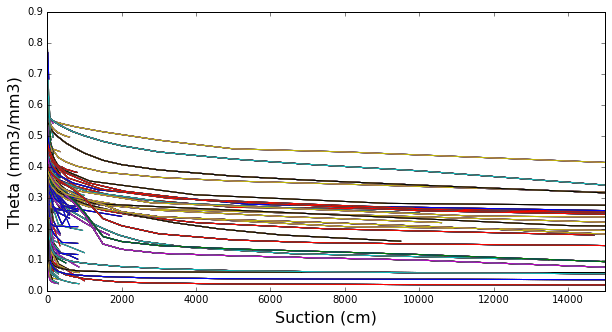

In [6]:
fig = plt.figure(figsize=(10,5))

for soil in Data.index:
    plt.plot(Data.ix[soil,'preshead'],Data.ix[soil,'theta'])
plt.xlim(0,15000)
plt.ylabel('Theta (mm3/mm3)',fontsize=16)
plt.xlabel('Suction (cm)',fontsize=16)

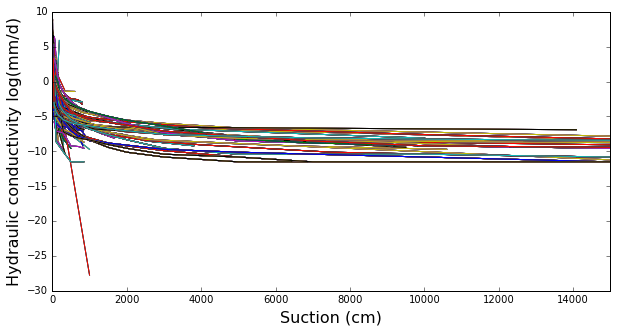

In [7]:
fig = plt.figure(figsize=(10,5))

for soil in Data.index:
    plt.plot(Data.ix[soil,'preshead'],np.log(Data.ix[soil,'conductivity']))
plt.xlim(0,15000)
plt.ylabel('Hydraulic conductivity log(mm/d)',fontsize=16)
plt.xlabel('Suction (cm)',fontsize=16)


## Quite alot of soils have insufficient range in their k and theta measurements to be useful.  
## Filter out anything that has a narrow range of measurements

In [8]:
#This cell throws a copy slice error and takes a long time to run, but it still does what is intended.
Data.ix[:,'FullSet'] = 'false'
for soil in Data.index:
    if Data.ix[soil,'preshead'].max() >= 15000 and Data.ix[soil,'preshead'].min() <= 100:
        Data.ix[soil,'FullSet'] = 'true'

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:284: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:461: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [9]:
SetFilter = Data.ix[:,'FullSet'] == 'true'

In [10]:
FullData = Data.ix[SetFilter,:].copy()

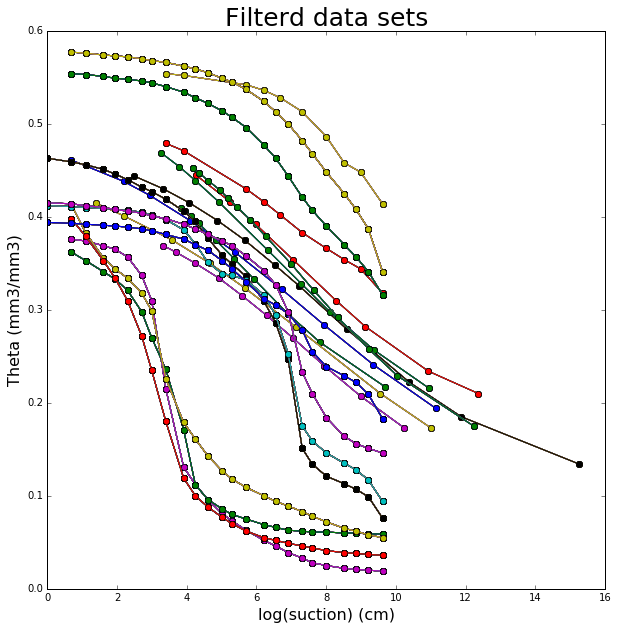

In [11]:
fig = plt.figure(figsize=(10,10))

for soil in FullData.index:
    plt.plot(np.log(FullData.ix[soil,'preshead']),FullData.ix[soil,'theta'],'o-')
plt.ylabel('Theta (mm3/mm3)',fontsize=16)
plt.xlabel('log(suction) (cm)',fontsize=16)
plt.title('Filterd data sets', fontsize=25)


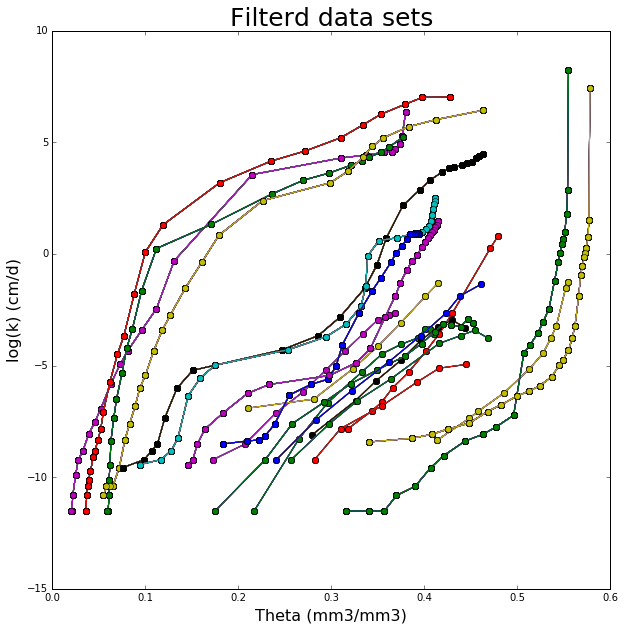

In [12]:
fig = plt.figure(figsize=(10,10))

for soil in FullData.index:
    plt.plot(FullData.ix[soil,'theta'],np.log(FullData.ix[soil,'conductivity']),'o-')
plt.xlabel('Theta (mm3/mm3)',fontsize=16)
plt.ylabel('log(k) (cm/d)',fontsize=16)
plt.title('Filterd data sets', fontsize=25)

## Now we have a data set we can work with lets calculate some things

### Index bits for a start

In [13]:
FullData.sort_values(by=['code','preshead'],inplace=True)

In [14]:
FullData.ix[:,'IntCode']=[x for x in range(FullData.index.size)]

In [15]:
FullData.ix[:,'SampleCode'] = 0

In [16]:
StartCode = 0
for x in FullData.index:
    code = range(StartCode,StartCode + FullData.ix[x,'SampleCode'].size)
    Soil = FullData.ix[x,'SampleCode'] = code

## Set up some arbitary pore compartments 

### assuming the largest compartments upper diameter is that of the lowest measured pressure and the lower diameter of the smallest pore is zero

In [17]:
FullData.set_index('IntCode',inplace=True)

In [18]:
FullData.ix[:,'UpperDiameter'] = 3000/FullData.ix[:,'preshead']

In [19]:
FullData.ix[:,'LowerDiameter'] = 0

In [20]:
def LowerDia(x):
    if x == 348:
        ret_val = 0
    else:
        if FullData.ix[x,'code'] != FullData.ix[x+1,'code']:
            ret_val = 0
        else:
            ret_val = FullData.ix[x+1,'UpperDiameter']
        return ret_val

In [21]:
FullData.ix[:,'LowerDiameter'] = [LowerDia(x) for x in range(FullData.index.size)]

In [22]:
def thetaLower(x):
    if x == 348:
        ret_val = 0
    else:
        if FullData.ix[x,'code'] != FullData.ix[x+1,'code']:
            ret_val = 0
        else:
            ret_val = FullData.ix[x+1,'theta']
    return ret_val

In [23]:
FullData.ix[:,'ThetaLower'] = [thetaLower(x) for x in range(FullData.index.size)]

### The radius of each more compartment is the mean of its upper and lower diameters

In [24]:
FullData.ix[:,'PoreRadius'] = np.add(FullData.ix[:,'UpperDiameter'],FullData.ix[:,'LowerDiameter'])/4

### The volume of each pore compartment is derived from theta at its upper and lower boundary

In [25]:
FullData.ix[:,'Volume'] = FullData.ix[:,'theta'] - FullData.ix[:,'ThetaLower']

### The area of individual pore columns in each compartment is calcualted from its radius

In [26]:
FullData.ix[:,'Area'] = np.pi * np.power(FullData.ix[:,'PoreRadius'],2)

### The number of pore columns in each compartment is calculated from its radius and the horizontal area of the compartment, assumed to be equivelent to its pore volume (mm3/mm3)

In [27]:
FullData.ix[:,'Number'] = np.divide(FullData.ix[:,'Volume'],np.divide(FullData.ix[:,'Area'], 1000000000000))

## Now we have all the bits in place to calculate the k curve of the soil from its theta curve.  

This is done as follows

For each pore compartment we estimate a volumetric flow rate per pore column as:

$FlowRate = Cflow * Radius^{3.6}$

The the volumetric flow through that pore compartment as:

$VolumetricFlow = FlowRate * Number$

Then the hydraulic conductivity at a given suction is calculated by summing the conductivity of the pores that are water filled at and below that suction of each pore boundary

In [28]:
FullData.iloc[:5]

,code,preshead,theta,conductivity,FullSet,SampleCode,UpperDiameter,LowerDiameter,ThetaLower,PoreRadius,Volume,Area,Number
IntCode,,,,,,,,,,,,,
0,2360,30.0,0.479,2.200,true,0,100.00,60.00,0.471,40.0000,0.008,5026.548246,1.591549e+06
1,2360,50.0,0.471,1.300,true,1,60.00,10.00,0.430,17.5000,0.041,962.112750,4.261455e+07
2,2360,300.0,0.430,0.070,true,2,10.00,6.00,0.416,4.0000,0.014,50.265482,2.785212e+08
3,2360,500.0,0.416,0.028,true,3,6.00,3.75,0.402,2.4375,0.014,18.665478,7.500478e+08
4,2360,800.0,0.402,0.013,true,4,3.75,2.00,0.383,1.4375,0.019,6.491807,2.926766e+09


In [29]:
FullData.ix[:,'HydraulicConductivity'] = 0

### Calculate the hydraulic flow rate through a single pore compartment from pore size and number

In [30]:
def flowRate(Radius):
    Cflow = .01
    Xflow = 1.6 + 2*np.exp(Radius*-0.008)
    return Cflow * np.power(Radius/1000,Xflow)

In [31]:
FullData.ix[:,'FlowRate'] =  [flowRate(FullData.ix[x,'PoreRadius']) for x in range(FullData.index.size)]

In [32]:
FullData.ix[:,'VolumetricFlow'] =  FullData.ix[:,'FlowRate'] * FullData.ix[:,'Number']

### Accumulate flow rates for current and smaller pores to calculate k at tension when this pore if full (i.e k curve)

In [33]:
def AccumCond(x):
    if x == 348:
        ret_val = FullData.ix[x,'VolumetricFlow']
    else:
        if FullData.ix[x,'code'] != FullData.ix[x+1,'code']:
            ret_val = FullData.ix[x,'VolumetricFlow']
        else:
            ret_val = FullData.ix[x,'VolumetricFlow'] + FullData.ix[x+1,'HydraulicConductivity']
    return ret_val

In [34]:
for x in reversed(range(FullData.index.size)):
    FullData.ix[x,'HydraulicConductivity'] = AccumCond(x)

### The cell below allows trialling of different ways of estimating Cflow and compares the hydraulic conductivity values that result agains those that were observed

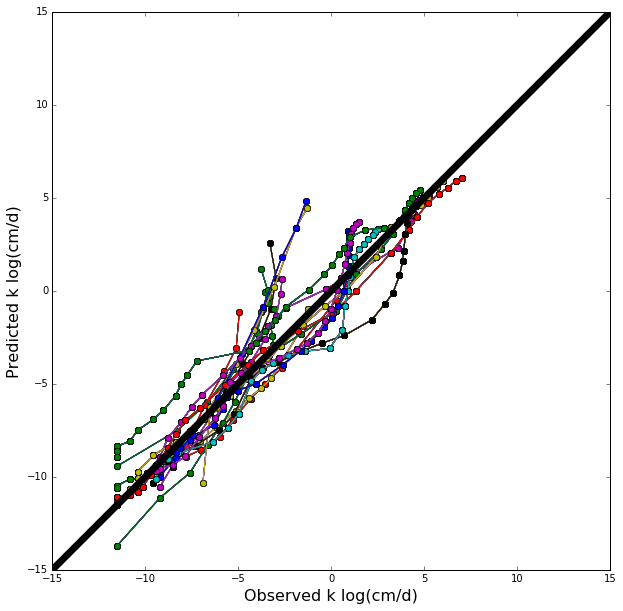

In [35]:
GraphData = FullData.set_index('code')

fig = plt.figure(figsize=(10,10))

for soil in GraphData.index:
    plt.plot(np.log(GraphData.ix[soil,'conductivity']),np.log(GraphData.ix[soil,'HydraulicConductivity']),'o-')
plt.ylabel('Predicted k log(cm/d)',fontsize=16)
plt.xlabel('Observed k log(cm/d)',fontsize=16)
plt.plot([-15,15],[-15,15],linewidth=7)

Cflow = plt.figure(figsize=(10,5))

## It appears that assuming Cflow increases with pore radius works OK??